# Tidal Flow Calculator

*(Greg Tucker, July 2020)*

This tutorial explains the theory behind the `TidalFlowCalculator` Landlab component, and shows how to use the component in an example.

## Theory

The `TidalFlowCalculator` computes a tidal-cycle averaged flow velocity field, given a topography (bathymetry), mean sea level, tidal range, and tidal period. The approach that the component uses is based on Mariotti (2018). The idea is to calculate a flow velocity field that is just sufficient to bring in (flood tide) or send out (ebb tidal) all of the water that enters or leaves the system during one tidal cycle.

The inertial terms in the shallow-water momentum equations are assumed to be negligible, so that the operative driving forces are gravity and pressure (represented by the water-surface slope), and the resisting force is friction. The resulting relationship between velocity, depth, roughness, and water-surface slope is linearized into the following form:

$$U = -\frac{h^{4/3}}{n^2\chi} \nabla\eta$$ (1)

Here, $U$ is velocity (2D vector), $h$ is tidal-averaged water depth, $n$ is roughness, $\chi$ is a scale velocity, and $\eta = h + z$ is water surface elevation (and $z$ is bed surface elevation). The equation above represents momentum conservation (note that $U$ and $\nabla\eta$ are vectors, representing the $x$ and $y$ components of flow velocity and water-surface gradient, respectively).

The method uses a steady form of the mass-conservation equation---again, the idea is that we're seeking a flow velocity field that is just sufficient to carry in or out all the water that enters or exits during a tidal cycle. The mass conservation equation is:

$$\nabla \cdot \mathbf{q} = I$$

Here, $\mathbf{q} = U h$ is the volume flow per unit width (again, a two-dimensional vector). The variable $I$ is "the distributed input of water over half a tidal cycle" (Mariotti, 2018), defined as

$$I(x,y) = \left[r/2 − \max(−r/2, \min(z(x,y), r/2))\right]/(T/2)$$

where $r$ is the tidal range [L] and $T$ is the tidal period [T]. In the expression above, if the water at a point $(x,y)$ is deeper than the tidal amplitude (i.e, half the tidal range, or $r/2$), then the depth of inundation or drainage during half of a tidal cycle is simply the tidal range $r$. All of this water must enter or leave during half a tidal cycle, or $T/2$. Therefore the **rate** [L/T] of inundation or drainage is equal to the depth divided by $T/2$. Again, if the water is deeper than $r/2$, the rate is just $2r/T$.

Our goal is to calculate $U$ at each location. We get it by solving for $\eta$ then using equation (1) to calculate $U$. It turns out that we can formulate this as a Poisson equation: a steady diffusion equation, in this case in two (horizontal) dimensions. First, approximate that $h$, $n$ are uniform (even though they aren't, in the general problem). Substituting

$$\nabla U h = \nabla \frac{h^{7/3}}{n^2\chi} \nabla\cdot\eta = \frac{h^{7/3}}{n^2\chi} \nabla^2 \eta$$

Plugging this into our mass conservation law

$$\frac{h^{7/3}}{n^2\chi} \nabla^2 \eta = I$$

This can be rearranged to:

$$\nabla^2\eta = \frac{In^2\chi}{h^{7/3}}$$ (2)

This is the Poisson problem to be solved numerically.

Note that $I$ is positive on the flood tide and negative on the ebb tide.

## Numerical methods

The `TidalFlowCalculator` uses a finite-volume method to solve Equation (2) numerically at the core nodes of a Landlab grid. The grid must be either a `RasterModelGrid` or a `HexModelGrid`. You can find a discussion of finite-volume methods in the tutorial for Landlab's matrix-building utility. Here, a quick sketch of the solution method is as follows. The governing mass conservation equation is:

$$\nabla\cdot \mathbf{q} = I$$

The basis for the 2d finite-volume method is to integrate both sides of the equation over a region $R$, representing a grid cell. Then Green's theorem is used to turn the divergence term into a line integral of the flux around the perimeter of the region, $S$. The above equation becomes

$$\oint_S \mathbf{q} \mathbf{n} dS = IA_c$$

where $A_c$ is the surface area of the region and $\mathbf{n}$ is the outward unit vector normal to the perimeter of the region. When the region is a grid cell with $N$ faces of width $w$, the above becomes

$$\sum_{k=1}^N q_k \delta_k w = IA_c$$

where $q_k$ is the magnitude of $q$ in the face-perpendicular direction at cell face $k$, and $\delta$ is either 1 or -1, depending on the orientation of the grid link that crosses the face. For a `RasterModelGrid`, $N=4$, and for a `HexModelGrid`, $N=6$.

As discussed in the tutorial *Building a matrix for numerical methods using a Landlab grid*, when $q$ depends on the gradient in some field (in this case, water-surface elevation), the above equation can be translated into a matrix equation of the form $A\mathbf{x}=\mathbf{b}$, whose solution gives the solution to the Poisson equation.

## Examples

### One-dimensional case

Consider a one dimensional domain with open water at the east (right) side and a closed boundary (e.g., seawall) at the west (left) side. Assume that the mean water depth is larger than the tidal amplitude, so that the sea bed is never exposed, even at low tide. Imagine that our tidal range is 2 meters, the water depth is 50 meters, and (to make the math a bit easier) the tidal period is 40,000 seconds. The analytical solution for flow discharge, $q$, can be found by noting that at any given distance from the sea wall, $q$ must be just enough to carry out all the outgoing water (ebb tide) or carry in all the incoming water (flood tide). The rate of inflow or outflow is equal to the inundation/drainage rate $I$ times distance from the sea wall, $x$:

$$q = -I x$$

The negative sign just means that $q$ is positive (flow to the right/east) when the tide is going out (negative $I$) and negative (flow to the left/west) when the tide is coming in. The velocity is

$$U = -I x / h$$

Here, $h$ is a function of $x$, but with a modest roughness (Manning's $n$) of 0.01 and relatively deep water, we can get a good approximation using just the tidal-average depth of 50 m. With this approximation, we expect the solution to be:

$$U = \pm \frac{(2 m)}{(50 m) \cdot (2\times 10^4 s)} x = 2\times 10^{-6} x$$

The code below runs the component for these conditions, and compares the solution with this analytical solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid
from landlab.components import TidalFlowCalculator

0.00038123130798339844
0.009699821472167969
0.0012102127075195312
0.0010380744934082031
0.008939743041992188
0.0004100799560546875
0.000186920166015625


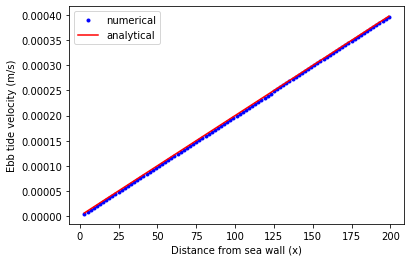

In [2]:
# set up the grid
grid = RasterModelGrid((3, 101), xy_spacing=2.0)  # only 1 row of core nodes, between 2 boundary rows
grid.set_closed_boundaries_at_grid_edges(False, True, True, True)  # only east/right side open
z = grid.add_zeros('topographic__elevation', at='node')
z[:] = -50.0  # water depth

# create the component
tfc = TidalFlowCalculator(grid, tidal_range=2.0, tidal_period=4.0e4, roughness=0.01)

# run the component
tfc.run_one_step()

# calculate the analytical solution
x = np.arange(3.0, 200.0, 2.0)
vel_analytical = 2.0e-6 * x

# plot both
plt.plot(x, grid.at_link['ebb_tide_flow__velocity'][grid.active_links], 'b.')
plt.plot(x, vel_analytical, 'r')
plt.xlabel('Distance from sea wall (x)')
plt.ylabel('Ebb tide velocity (m/s)')
plt.legend(['numerical', 'analytical'])

As we would expect, the numerical solution is slightly lower than the analytical solution, because our simplified analytical solution does not take into account the extra water depth whose gradient propels the ebb tide. (Exercise to the reader: develop the analytical solution for water surface elevation, and then use it to derive a correct flow velocity that accounts for a little bit of extra depth at ebb tide, and a little less depth at flood tide.)

### Idealized two-dimensional case

Here we use a rectangular domain with two open sides and two closed sides.

0.0009179115295410156
0.05026984214782715
0.0010790824890136719
0.0008890628814697266
0.048584938049316406
0.000820159912109375
0.00030994415283203125


Text(0, 0.5, 'Distance (m)')

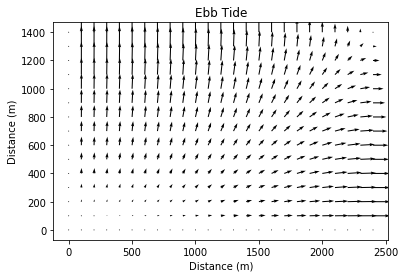

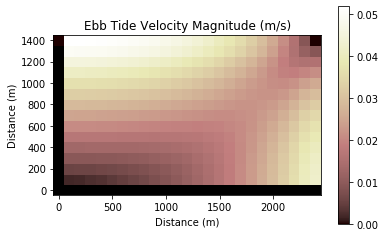

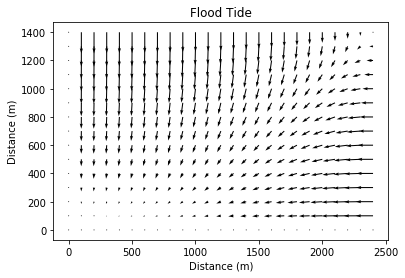

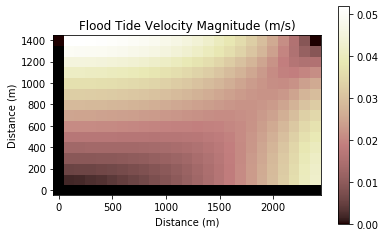

In [3]:
# parameters
nrows = 15
ncols = 25
grid_spacing = 100.0  # m
mean_depth = 2.0  # m
tidal_range = 2.0  # m
roughness = 0.01  # s/m^1/3, i.e., Manning's n

# create and set up the grid
grid = RasterModelGrid((nrows, ncols), xy_spacing=grid_spacing)
z = grid.add_zeros('topographic__elevation', at='node')
z[:] = -mean_depth
grid.set_closed_boundaries_at_grid_edges(False, False, True, True)

# instantiate the TidalFlowCalculator
tfc = TidalFlowCalculator(grid, tidal_range=2.0, roughness=0.01)

# run it
tfc.run_one_step()

# map the velocity components from the links to the nodes
ebb_vel_x = grid.map_mean_of_horizontal_links_to_node(grid.at_link['ebb_tide_flow__velocity'])
ebb_vel_y = grid.map_mean_of_vertical_links_to_node(grid.at_link['ebb_tide_flow__velocity'])
flood_vel_x = grid.map_mean_of_horizontal_links_to_node(grid.at_link['flood_tide_flow__velocity'])
flood_vel_y = grid.map_mean_of_vertical_links_to_node(grid.at_link['flood_tide_flow__velocity'])

# make plots...

# ebb tide
plt.figure()
plt.quiver(grid.x_of_node, grid.y_of_node, ebb_vel_x.reshape(nrows, ncols), ebb_vel_y.reshape(nrows, ncols))
plt.title('Ebb Tide')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
ebb_vel_magnitude = np.sqrt(ebb_vel_x * ebb_vel_x + ebb_vel_y * ebb_vel_y)
plt.figure()
imshow_grid(grid, ebb_vel_magnitude)
plt.title('Ebb Tide Velocity Magnitude (m/s)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

# flood tide
plt.figure()
plt.quiver(grid.x_of_node, grid.y_of_node, flood_vel_x.reshape(nrows, ncols), flood_vel_y.reshape(nrows, ncols))
plt.title('Flood Tide')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.figure()
flood_vel_magnitude = np.sqrt(flood_vel_x * flood_vel_x + flood_vel_y * flood_vel_y)
imshow_grid(grid, flood_vel_magnitude)
plt.title('Flood Tide Velocity Magnitude (m/s)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')


### Case study based on example in Giulio Mariotti's MarshMorpho2D package

This example reads topography/bathymetry from a 2-meter resolution digital elevation model. Locations above mean high tide are flagged as closed boundaries.

0.014391183853149414
14.227813959121704
0.5283401012420654
0.02057504653930664
14.706916809082031
0.5257031917572021
0.007187843322753906


Text(0, 0.5, 'Distance (m)')

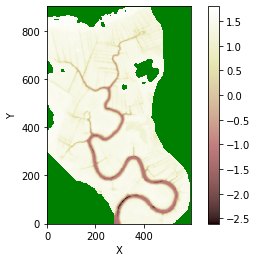

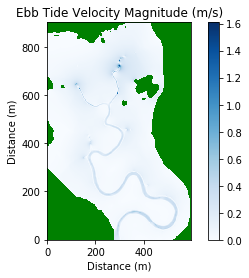

In [4]:
from landlab.io import read_esri_ascii

# Set parameters (these are from the MarshMorpho2D source code)
tidal_period = 12.5 * 3600.0  # tidal period in seconds
tidal_range = 3.1  # tidal range in meters
roughness = 0.02  # Manning's n
mean_sea_level = 0.0  # mean sea level in meters
min_water_depth = 0.01  # minimum depth for water on areas higher than low tide water surface, meters
nodata_code = 999  # code for a DEM cell with no valid data

# Read the DEM to create a grid and topography field
(grid, z) = read_esri_ascii('zSW3.asc', name='topographic__elevation')

# Configure boundaries: any nodata nodes, plus any nodes higher than mean high tide
grid.status_at_node[z==nodata_code] = grid.BC_NODE_IS_CLOSED
grid.status_at_node[z>1.8] = grid.BC_NODE_IS_CLOSED
boundaries_above_msl = np.logical_and(grid.status_at_node==grid.BC_NODE_IS_FIXED_VALUE, z > 0.0)
grid.status_at_node[boundaries_above_msl] = grid.BC_NODE_IS_CLOSED

# Display the terrain
imshow_grid(grid, z, color_for_closed='g')

# Instantiate a TidalFlowCalculator component
tfc = TidalFlowCalculator(
        grid,
        tidal_period=tidal_period,
        tidal_range=tidal_range,
        roughness=roughness,
        mean_sea_level=mean_sea_level,
        min_water_depth=min_water_depth,
)

# Calculate tidal flow
tfc.run_one_step()

# Display the results
# map the velocity components from the links to the nodes
ebb_vel_x = grid.map_mean_of_horizontal_links_to_node(grid.at_link['ebb_tide_flow__velocity'])
ebb_vel_y = grid.map_mean_of_vertical_links_to_node(grid.at_link['ebb_tide_flow__velocity'])
flood_vel_x = grid.map_mean_of_horizontal_links_to_node(grid.at_link['flood_tide_flow__velocity'])
flood_vel_y = grid.map_mean_of_vertical_links_to_node(grid.at_link['flood_tide_flow__velocity'])

ebb_vel_magnitude = np.sqrt(ebb_vel_x * ebb_vel_x + ebb_vel_y * ebb_vel_y)
plt.figure()
imshow_grid(grid, ebb_vel_magnitude, cmap='Blues', color_for_closed='g')
plt.title('Ebb Tide Velocity Magnitude (m/s)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')


We can also use a quiver plot to show the velocity vectors. The grid is too dense to show the vectors at every grid node, so we will down-sample first. Here's how:

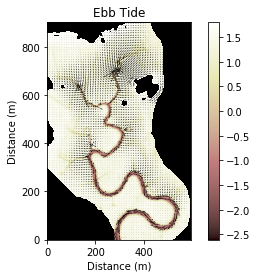

In [5]:
# Down-sample to a coarser grid
ds = 5
x_subsamp = grid.x_of_node.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[::ds, ::ds]
y_subsamp = grid.y_of_node.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[::ds, ::ds]
ebb_vel_x_subsamp = ebb_vel_x.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[::ds, ::ds]
ebb_vel_y_subsamp = ebb_vel_y.reshape((grid.number_of_node_rows, grid.number_of_node_columns))[::ds, ::ds]

# Plot velocity vectors over topography/bathymetry
plt.figure()
imshow_grid(grid, z)
plt.quiver(x_subsamp, y_subsamp, ebb_vel_x_subsamp, ebb_vel_y_subsamp)
plt.title('Ebb Tide')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
plt.savefig('frogvector.pdf')

### Example with hex grid

(452, 300)


Text(0, 0.5, 'Distance (m)')

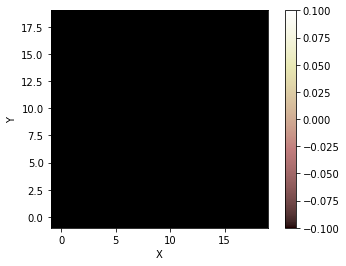

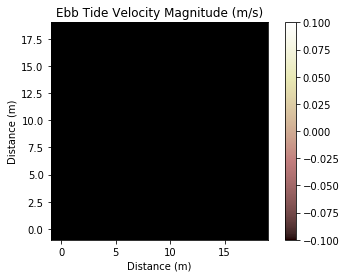

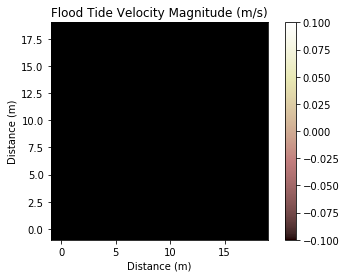

In [6]:
(demgrid, z) = read_esri_ascii('zSW3.asc', name='topographic__elevation')
print(demgrid.shape)
zz = z.reshape((demgrid.number_of_node_rows, demgrid.number_of_node_columns))
nrows = 10
ncols = 10
zzsub = zz[0:nrows,0:ncols]
subgrid = RasterModelGrid(zzsub.shape, xy_spacing=2.0)
zsub = subgrid.add_zeros('topographic__elevation', at='node')
zsub[:] = zzsub.flatten()
#subgrid.set_closed_boundaries_at_grid_edges(True, True, True, False)
subgrid.status_at_node[zsub>900] = subgrid.BC_NODE_IS_CLOSED
subgrid.status_at_node[zsub>tidal_range] = subgrid.BC_NODE_IS_CLOSED
interesting = np.logical_and(subgrid.status_at_node==subgrid.BC_NODE_IS_FIXED_VALUE,
                             zsub > 0.0)
subgrid.status_at_node[interesting] = subgrid.BC_NODE_IS_CLOSED
imshow_grid(subgrid, zsub)

tfcsub = TidalFlowCalculator(
        subgrid,
        tidal_period=tidal_period,
        tidal_range=tidal_range,
        roughness=roughness,
        mean_sea_level=mean_sea_level,
        min_water_depth=min_water_depth,
)

#tfcsub.run_one_step()

# Display the results
# map the velocity components from the links to the nodes
ebb_vel_x = subgrid.map_mean_of_horizontal_links_to_node(subgrid.at_link['ebb_tide_flow__velocity'])
ebb_vel_y = subgrid.map_mean_of_vertical_links_to_node(subgrid.at_link['ebb_tide_flow__velocity'])
flood_vel_x = subgrid.map_mean_of_horizontal_links_to_node(subgrid.at_link['flood_tide_flow__velocity'])
flood_vel_y = subgrid.map_mean_of_vertical_links_to_node(subgrid.at_link['flood_tide_flow__velocity'])

ebb_vel_magnitude = np.sqrt(ebb_vel_x * ebb_vel_x + ebb_vel_y * ebb_vel_y)
plt.figure()
imshow_grid(subgrid, ebb_vel_magnitude)
plt.title('Ebb Tide Velocity Magnitude (m/s)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')

#plt.figure()
#plt.quiver(subgrid.x_of_node, subgrid.y_of_node, ebb_vel_x.reshape(nrows, ncols), ebb_vel_y.reshape(nrows, ncols))
#plt.title('Ebb Tide')
#plt.xlabel('Distance (m)')
#plt.ylabel('Distance (m)')

# flood tide
plt.figure()
flood_vel_magnitude = np.sqrt(flood_vel_x * flood_vel_x + flood_vel_y * flood_vel_y)
imshow_grid(subgrid, flood_vel_magnitude)
plt.title('Flood Tide Velocity Magnitude (m/s)')
plt.xlabel('Distance (m)')
plt.ylabel('Distance (m)')
#plt.figure()
#plt.quiver(subgrid.x_of_node, subgrid.y_of_node, flood_vel_x.reshape(nrows, ncols), flood_vel_y.reshape(nrows, ncols))
#plt.title('Flood Tide')
#plt.xlabel('Distance (m)')
#plt.ylabel('Distance (m)')
